# Classifier Evaluation using Precision, Recall, and ROC
We are going to apply logistic regression using the data available from the <a href="https://www.lendingclub.com/info/download-data.action">Lending Club Corporation</a>. The company provides files containing complete loan data for all loans issued through a certain time period, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information.

We are going to use a small subset of the available data which were previously preprocessed.

The goal of this notebook is to explore the different ways we can use to evaluate the result of classification.

As the very first step, we load all the relevant libraries.

In [1]:
# Usual libraries for tools
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
import matplotlib.pyplot as plt

# Libraries for the evaluation
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score




%matplotlib inline

Then, we load the data.

In [2]:
# loans = pd.read_csv('LoansData01.csv')
loans = pd.read_csv('LoansNumerical.csv')

In [3]:
loans.head(5)

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment,num_term,grade_num,loan_amnt,safe_loans
0,0.4,0,11,27.65,8.14350,0.0,1.0,1.0,1,1,...,10.65,861.07,24000.0,5000,4975,162.87,36,5,5000,1
1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,1,...,15.27,435.17,30000.0,2500,2500,59.83,60,4,2500,-1
2,1.0,0,11,8.72,8.25955,0.0,1.0,2.0,1,1,...,15.96,603.65,12252.0,2400,2400,84.33,36,4,2400,1
3,0.2,0,11,20.00,8.27585,0.0,1.0,1.0,0,1,...,13.49,2209.33,49200.0,10000,10000,339.31,36,4,10000,1
4,0.8,0,4,11.20,5.21533,0.0,1.0,3.0,1,1,...,7.90,631.38,36000.0,5000,5000,156.46,36,6,5000,1


In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122462 entries, 0 to 122461
Data columns (total 25 columns):
sub_grade_num            122462 non-null float64
short_emp                122462 non-null int64
emp_length_num           122462 non-null int64
dti                      122462 non-null float64
payment_inc_ratio        122462 non-null float64
delinq_2yrs              122462 non-null float64
delinq_2yrs_zero         122462 non-null float64
inq_last_6mths           122462 non-null float64
last_delinq_none         122462 non-null int64
last_major_derog_none    122462 non-null int64
open_acc                 122462 non-null float64
pub_rec                  122462 non-null float64
pub_rec_zero             122462 non-null float64
revol_util               122462 non-null float64
total_rec_late_fee       122462 non-null float64
int_rate                 122462 non-null float64
total_rec_int            122462 non-null float64
annual_inc               122462 non-null float64
funded_amnt    

In [5]:
target = 'safe_loans'
features = loans.columns[loans.columns!=target]

print(features)
print(len(features))

Index([u'sub_grade_num', u'short_emp', u'emp_length_num', u'dti',
       u'payment_inc_ratio', u'delinq_2yrs', u'delinq_2yrs_zero',
       u'inq_last_6mths', u'last_delinq_none', u'last_major_derog_none',
       u'open_acc', u'pub_rec', u'pub_rec_zero', u'revol_util',
       u'total_rec_late_fee', u'int_rate', u'total_rec_int', u'annual_inc',
       u'funded_amnt', u'funded_amnt_inv', u'installment', u'num_term',
       u'grade_num', u'loan_amnt'],
      dtype='object')
24


From the data dictionary available on the <a href="https://www.lendingclub.com/info/download-data.action">Lending Club Corporation</a> website, we have the description of the variables: 

- <b>sub_grade_num</b>, the sub-grade of the loan as a number from 0 to 1
- <b>short_emp</b>, one year or less of employment
- emp_length_num, number of years of employment
- <b>dti</b>, debt to income ratio
- <b>payment_inc_ratio</b>, ratio of the monthly payment to income
- <b>delinq_2yrs</b>, number of delinquincies
- <b>delinq_2yrs_zero</b>, no delinquincies in last 2 years
- <b>inq_last_6mths</b>, number of creditor inquiries in last 6 months
- <b>last_delinq_none</b>, has borrower had a delinquincy
- <b>last_major_derog_none</b>, has borrower had 90 day or worse rating
- <b>open_acc</b>, number of open credit accounts
- <b>pub_rec</b>, number of derogatory public records
- <b>pub_rec_zero</b>, no derogatory public records
- <b>revol_util</b>, percent of available credit being used
- <b>total_rec_late_fee</b>, total late fees received to day
- <b>int_rate</b>, interest rate of the loan
- <b>total_rec_int</b>, interest received to date
- <b>annual_inc</b>,  annual income of borrower
- <b>funded_amnt</b>, amount committed to the loan
- <b>funded_amnt_inv</b>, amount committed by investors for the loan
- <b>installment</b>, monthly payment owed by the borrower
- <b>num_term</b>, number of payments on the loan. Values are in months and can be either 36 or 60
- <b>grade_num</b>, LC assigned loan grade as a number
- <b>loan_amnt</b>, the listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

The target variable (the class) is <b>safe_loans</b> that is +1 if the loan is safe -1 if it is risky

The input variables x are the columns corresponding to the features, the output variable y is the column corresponding to the target variable.

In [6]:
x = loans[features]
y = loans[target]

First we apply plain logistic regression without regularization (thus $\alpha$ is zero). The Scikit-learn function does not allow to specify $\alpha$ but it uses a parameter C=1/$\alpha$. Accordingly, to have no regularization we need to specify a huge value of C. And we evaluate the model using plain crossvalidation.

In [7]:
simple_logistic = linear_model.LogisticRegression(C=10e10)
simple_logistic.fit(x,y);
simple_eval = model_selection.cross_val_score(simple_logistic, x, y, cv=10)
print("Simple Logistic Regression\t%3.2f\t%3.2f" % (np.average(simple_eval), np.std(simple_eval)))

Simple Logistic Regression	0.81	0.01


## Evaluating Classification - Accuracy
Accuracy is the most known and most widely used measure of classification performance. It measure the percentage of correct classification achieved by the model.

$accuracy = \frac{number of correclty classified examples}{number of examples}$


## Confusion Matrix
Accuracy evaluates the percentage of correct predictions but not the errors are equal. To have a better sense of how a classifier model performs the confusion matrix is usually examined. The confusion matrix includes

- <b>the true positives,</b> the number of examples labeled as positives and prediceted as positives
- <b>the true negatives,</b> the number of examples labeled as negatives and prediceted as negatives
- <b>the false positives,</b> the number of examples labeled as negatives and prediceted as positives
- <b>the false negatives,</b> the number of examples labeled as positives and prediceted as negatives

The confusion matrix is typically shown as,


|  | Predicted Positive | Predicted Negative |
|-----------------:|:------------------:|:------------------:|
| Labeled Positive | TP | FN |
| Labeled Negative | FP | TN | 

We can compute the confusion matrix for the three models we developed.

In [8]:
yp = simple_logistic.predict(x);

def PrintConfusionMatrix(model, true_y, predicted_y, positive=1, negative=-1):
    cm = confusion_matrix(true_y,predicted_y)
    print("\t"+str(model.classes_[0])+"\t"+str(model.classes_[1]))
    print(str(model.classes_[0]) + "\t",cm[0][0],"\t",cm[0][1])
    print(str(model.classes_[1]) + "\t",cm[1][0],"\t",cm[1][1])

print("Confusion Matrix - Simple Logistic")
PrintConfusionMatrix(simple_logistic, y, yp)

Confusion Matrix - Simple Logistic
	-1	1
('-1\t', 307, '\t', 22815)
('1\t', 203, '\t', 99137)


## Precision and Recall
Precision and recall are alternative measures to plain accuracy introduced in the area of information retrieval and search engine. Precision focuses on the percentage of correctly classified positive examples or in the information retrieval context represents the percentage of actually good documents that have been shown as a result. Recall focuses on the percentage of positively classified examples with respect to the number of existing good documents or in the information retrieval context, recall represents the percentage of good documents shown with respect to the existing ones.

$precision = \frac{TP}{TP+FP}$

$recall = \frac{TP}{TP+FN}$

In [20]:
print("Precision %3.2f" % precision_score(y,yp))
print("Recall    %3.2f" % recall_score(y,yp))

Precision 0.81
Recall    1.00


## Probabilistic Models & Classification Thresholds
Up to now we used logistic regression to predict classifier labels, however, logistic regression typically returns a probability that an example should be label using a certain class. For example, the first example, is associated to two probabilities one corresponding to label -1 and one corresponding to label +1.

In [10]:
x.head(1)

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment,num_term,grade_num,loan_amnt
0,0.4,0,11,27.65,8.1435,0.0,1.0,1.0,1,1,...,0.0,10.65,861.07,24000.0,5000,4975,162.87,36,5,5000


In [11]:
yp = simple_logistic.predict(x)
yprob = simple_logistic.predict_proba(x)
print("Example %d:\n\tP(-1|x[%d])=%3.2f\n\tP(+1|x[%d])=%3.2f\n\t=> Labeled as %d" %(0 , 0, yprob[0,0], 0, yprob[0,1], yp[0]))

Example 0:
	P(-1|x[0])=0.29
	P(+1|x[0])=0.71
	=> Labeled as 1


The class assignment is based on the label with the largest probability so it is equivalent to using a threshold of 0.5 to decide which class to assign to an example. However, we might decide to use a different threshold and for instance label as positive only examples with a P(+1|x)>0.75 this would label as positive only cases for which we are more confident that should be labeled as positive.

In [12]:
def ClassifyWithThreshold(probabilities, threshold):
    return [+1 if x>=threshold else -1 for x in probabilities]
    
yp_confident = ClassifyWithThreshold(yprob[:,1],0.75)

print("Confusion Matrix - Simple Logistic (0.75)")
PrintConfusionMatrix(simple_logistic, y, yp_confident)

print("\n")
print("Precision %3.2f" % precision_score(y,yp_confident))
print("Recall    %3.2f" % recall_score(y,yp_confident))

Confusion Matrix - Simple Logistic (0.75)
	-1	1
('-1\t', 9084, '\t', 14038)
('1\t', 19631, '\t', 79709)


Precision 0.85
Recall    0.80


By increasing the threshold we increased the precision and thus we decreased the number of false positives while we increased the number of false negatives. Thus by modifying the threshold we can change the way our classifier makes mistakes. 

## Precision-Recall Curve
By modifying the threshold we can optimize our classifier to focus on one of the two metrics (precision or recall). To analyze precision varies depending on the threshold we can use the precision-recall curve which is computed by computing precision and recall from the threshold of 1 to the 0 threshold and plotting the result.

In [13]:
y_true = y
yp = simple_logistic.predict(x)
yprob = simple_logistic.predict_proba(x)
precision, recall, thresholds = precision_recall_curve(y_true=y, probas_pred=yprob[:,1])
auc = average_precision_score(y, yprob[:,1])

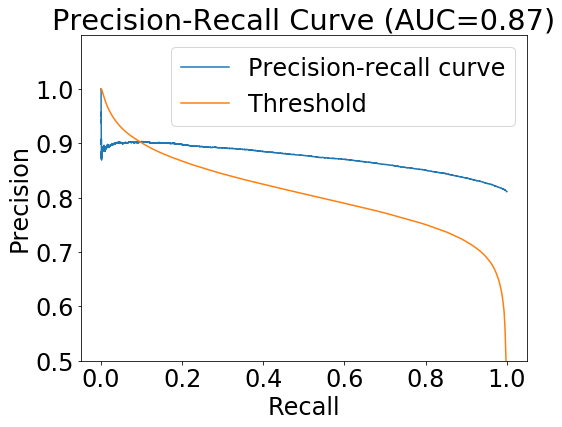

In [14]:
plt.figure(1, figsize=(8, 6));
font = {'family':'sans', 'size':24};
plt.rc('font', **font);
plt.plot(recall, precision, label="Precision-recall curve");
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.ylim([0.5,1.1])
plt.yticks(np.arange(0.5,1.01,.1))
plt.title('Precision-Recall Curve (AUC=%3.2f)'%auc);
plt.plot(recall[:-1],thresholds, label="Threshold");
plt.legend()
plt.show()

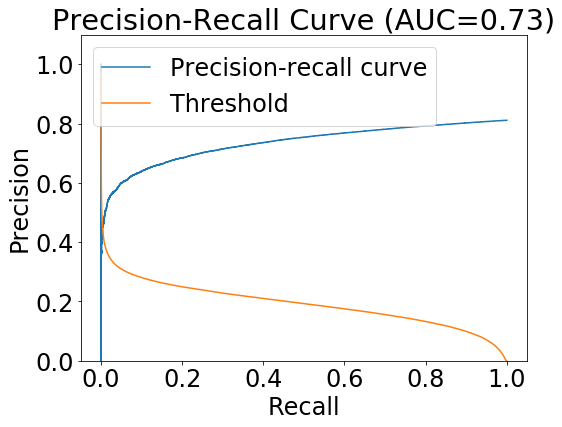

In [15]:
precision_neg, recall_neg, thresholds_neg = precision_recall_curve(y_true=y, probas_pred=yprob[:,0])
auc_neg = average_precision_score(y, yprob[:,0])
plt.figure(1, figsize=(8, 6));
font = {'family':'sans', 'size':24};
plt.rc('font', **font);
plt.plot(recall_neg, precision_neg, label="Precision-recall curve");
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.ylim([0.0,1.1])
plt.yticks(np.arange(0.0,1.01,.2))
plt.title('Precision-Recall Curve (AUC=%3.2f)'%auc_neg);
plt.plot(recall_neg[:-1],thresholds_neg, label="Threshold");
plt.legend()
plt.show()

## Receiver Operating Characteristic (ROC) Curves
Similar to precision-recall curves, they plot the True Positive Rate (TPR) against the False Positive Rate (FPR)

$TPR = \frac{TP}{TP+FN}$

$FPR = \frac{FP}{TN+FP}$


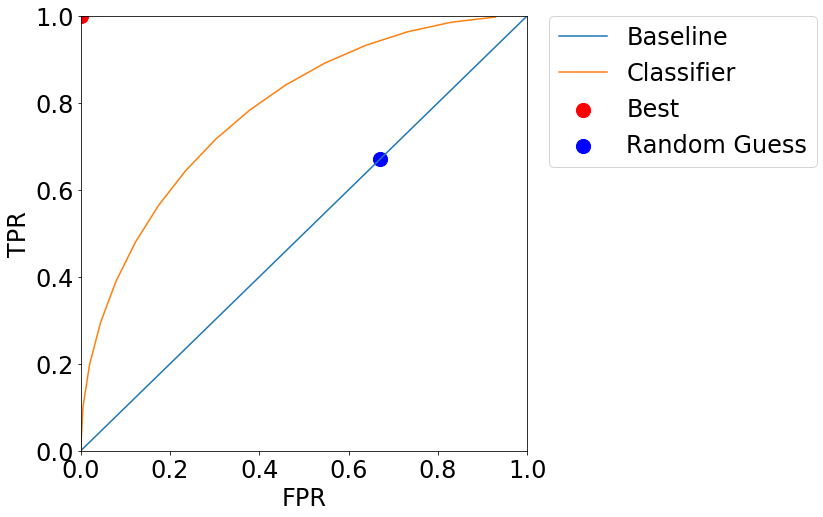

In [16]:
import math

plt.figure(1, figsize=(8, 8));
font = {'family':'sans', 'size':24};
plt.rc('font', **font);
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.plot([0.0,1.0],[0.0,1.0],label='Baseline')
# plt.plot([0.0,1.0],[1.0,1.0],color='gray')
# plt.plot([1.0,1.0],[0.0,1.0],color='gray')
angle=np.arange(math.pi, math.pi/2,-0.1)
fpr = np.cos(angle)+1.
tpr = np.sin(angle)
plt.plot(fpr,tpr,label='Classifier')
plt.yticks(np.arange(0.0,1.01,.2))
plt.scatter([0.0],[1.0], s=200, color='red', label='Best')
plt.scatter([0.67],[0.67], s=200, color='blue', label='Random Guess')


# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

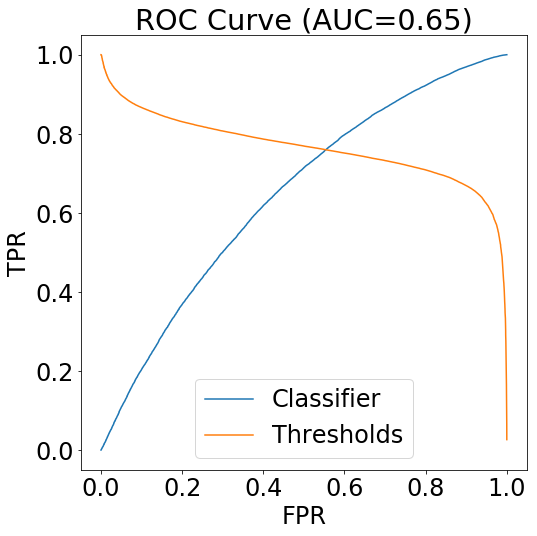

In [17]:
fpr, tpr, thresholds = roc_curve(y_true=y, y_score = yprob[:,1], pos_label=1)
roc_auc = roc_auc_score(y_true=y, y_score = yprob[:,1])
plt.figure(1, figsize=(8, 8));
font = {'family':'sans', 'size':24};
plt.rc('font', **font);
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.plot(fpr,tpr,label='Classifier')
plt.plot(fpr,thresholds,label='Thresholds')
plt.yticks(np.arange(0.0,1.01,.2))
plt.title('ROC Curve (AUC=%3.2f)'%roc_auc)
plt.legend()
plt.show();

As for the precision-recall curves, we can use the threshold value to search for the best TPR/FPR tradeoff.

The ideal value of AUC for a ROC curve is one however, it never happens. According, we look for classifiers with an AUC as large as possible and at least greater than Ideally, the AUC for ROC ion-recall curves, thus when selecting with two models we compare their AUC. 